### EMP data exploration - data found in [Polarization paper](https://www.nature.com/articles/s41559-020-01353-4) from Machado et al. (2021)

In [6]:
!conda env list

# conda environments:
#
base                     /home/ferreirav/miniconda3
gapseq                   /home/ferreirav/miniconda3/envs/gapseq
memote                   /home/ferreirav/miniconda3/envs/memote
project               *  /home/ferreirav/miniconda3/envs/project



In [7]:
%matplotlib inline

In [8]:
from glob import glob
import subprocess
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from carveme.reconstruction.ncbi_download import load_ncbi_table, download_ncbi_genome
import multiprocessing
import time

In [9]:
# Loading REFSEQ table with acession numbers
refseq = load_ncbi_table("./refseq_release_201.tsv")
refseq

,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,organism_name,infraspecific_name,isolate,version_status,...,release_type,genome_rep,seq_rel_date,asm_name,submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,relation_to_type_material
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000001215.4,PRJNA164,SAMN02803731,NaN,reference genome,7227,7227,Drosophila melanogaster,NaN,NaN,latest,...,Major,Full,2014/08/01,Release 6 plus ISO1 MT,The FlyBase Consortium/Berkeley Drosophila Gen...,GCA_000001215.4,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,NaN
GCF_000001405.39,PRJNA168,NaN,NaN,reference genome,9606,9606,Homo sapiens,NaN,NaN,latest,...,Patch,Full,2019/02/28,GRCh38.p13,Genome Reference Consortium,GCA_000001405.28,different,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,NaN
GCF_000001635.26,PRJNA169,NaN,NaN,reference genome,10090,10090,Mus musculus,NaN,NaN,latest,...,Patch,Full,2017/09/15,GRCm38.p6,Genome Reference Consortium,GCA_000001635.8,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,NaN
GCF_000001735.4,PRJNA116,SAMN03081427,NaN,reference genome,3702,3702,Arabidopsis thaliana,ecotype=Columbia,NaN,latest,...,Minor,Full,2018/03/15,TAIR10.1,The Arabidopsis Information Resource (TAIR),GCA_000001735.2,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,NaN
GCF_000001895.5,PRJNA12455,SAMN02808228,AABR00000000.7,representative genome,10116,10116,Rattus norvegicus,strain=mixed,NaN,latest,...,Major,Full,2014/07/01,Rnor_6.0,Rat Genome Sequencing Consortium,GCA_000001895.4,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_903995475.1,PRJNA224116,SAMEA7110814,CAJFAE000000000.1,na,766224,766224,Vibrio jasicida,NaN,Vibrio jasicida 20LP,latest,...,Major,Full,2020/08/20,ASM90399547v1,iBB-IST,GCA_903995475.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/903...,NaN,NaN
GCF_903995485.1,PRJNA224116,SAMEA7110813,CAJFAD000000000.1,na,170679,170679,Vibrio chagasii,NaN,Vibrio chagasii 18LP,latest,...,Major,Full,2020/08/20,ASM90399548v1,iBB-IST,GCA_903995485.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/903...,NaN,NaN
GCF_903995555.1,PRJNA224116,SAMEA7175806,CAJFAG000000000.1,na,316,316,Pseudomonas stutzeri,NaN,PSEUDT2.31D-1,latest,...,Major,Full,2020/08/20,PSEUDT2,CBMSO,GCA_903995555.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/903...,NaN,NaN


In [10]:
# Loading metadata
metadata = pd.read_csv("../data/emp_qiime_mapping_qc_filtered.tsv", sep="\t")

# change the name of columns
metadata.rename(columns={'#SampleID': 'sample'}, inplace=True)

metadata

,sample,BarcodeSequence,LinkerPrimerSequence,Description,host_subject_id,study_id,title,principal_investigator,doi,ebi_accession,...,adiv_shannon,adiv_faith_pd,temperature_deg_c,ph,salinity_psu,oxygen_mg_per_l,phosphate_umol_per_l,ammonium_umol_per_l,nitrate_umol_per_l,sulfate_umol_per_l
0,550.L1S1.s.1.sequence,AACGCACGCTAG,GTGCCAGCMGCCGCGGTAA,sample_1 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,...,4.244831,13.631804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,550.L1S10.s.1.sequence,ACAGACCACTCA,GTGCCAGCMGCCGCGGTAA,sample_2 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,...,3.027416,9.425835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,550.L1S100.s.1.sequence,ATGCACTGGCGA,GTGCCAGCMGCCGCGGTAA,sample_3 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,...,3.196420,10.491161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550.L1S101.s.1.sequence,ATTATCGTGCAC,GTGCCAGCMGCCGCGGTAA,sample_4 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,...,3.714719,11.384689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550.L1S102.s.1.sequence,CACGACAGGCTA,GTGCCAGCMGCCGCGGTAA,sample_5 stool,F4,550,Moving pictures of the human microbiome,Rob Knight,10.1186/gb-2011-12-5-r50,ERP021896,...,3.969038,15.162691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23823,2382.DPOO1.C1.HA.1.428.root.4.12.lane7.NoIndex...,ATGTTTAGACGG,GTGCCAGCMGCCGCGGTAA,Roots,HS10,2382,The soil microbiome influences grapevine-assoc...,Jack Gilbert,10.1128/mBio.02527-14,ERP006348,...,6.353810,50.767095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23824,2382.DPOO1.C1.HA.1.427.rhizo.4.12.lane7.NoInde...,GAAAGGTGAGAA,GTGCCAGCMGCCGCGGTAA,Rhizosphere,HS10,2382,The soil microbiome influences grapevine-assoc...,Jack Gilbert,10.1128/mBio.02527-14,ERP006348,...,9.465287,132.564052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23825,2382.DPOO1.C1.HA.1.23.root.6.11.lane1.NoIndex....,TACTGCCAGTGA,GTGCCAGCMGCCGCGGTAA,Roots,HS4,2382,The soil microbiome influences grapevine-assoc...,Jack Gilbert,10.1128/mBio.02527-14,ERP006348,...,8.246245,99.552115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23826,2382.DPOO1.C1.HA.1.23.r1.root.6.11.lane7.NoInd...,ACTTTGCTTTGC,GTGCCAGCMGCCGCGGTAA,Roots,HS10,2382,The soil microbiome influences grapevine-assoc...,Jack Gilbert,10.1128/mBio.02527-14,ERP006348,...,6.808210,68.164201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Loading samples
samples = pd.read_csv("../data/emp_150bp_filtered.tsv", sep="\t")
samples

,sample,org_id,value
0,1001.SKB1,Acidovorax_konjaci_DSM_7481,0.004495
1,1001.SKB1,Acidovorax_soli_DSM_25157,0.000642
2,1001.SKB1,Acinetobacter_brisouii_CIP_110357,0.000161
3,1001.SKB1,Acinetobacter_indicus_CIP_110367,0.004495
4,1001.SKB1,Actinomadura_meyerae_DSM_44715,0.000642
...,...,...,...
1409250,990.KA3U.E.25,Verrucomicrobium_spinosum_DSM_4136_JCM_18804,0.000089
1409251,990.KA3U.E.25,Verrucosispora_sediminis_CGMCC_4_3550,0.000333
1409252,990.KA3U.E.25,Viridibacillus_arvi_DSM_16317,0.000011
1409253,990.KA3U.E.25,Williamsia_muralis_NBRC_105860,0.000022


In [12]:
# Loading metadata for organism metabolic models
metabolic_models = pd.read_csv("../data/model_list.tsv", sep="\t", usecols=[0,4])
metabolic_models

,assembly_accession,file_path
0,GCF_000010525.1,models/a/azorhizobium/Azorhizobium_caulinodans...
1,GCF_000007365.1,models/b/buchnera/Buchnera_aphidicola_str_Sg_S...
2,GCF_000007725.1,models/b/buchnera/Buchnera_aphidicola_str_Bp_B...
3,GCF_000009605.1,models/b/buchnera/Buchnera_aphidicola_str_APS_...
4,GCF_000090965.1,models/b/buchnera/Buchnera_aphidicola_BCc.xml.gz
...,...,...
5583,GCF_002220865.1,models/b/bacillus/Bacillus_xerothermodurans_AT...
5584,GCF_002110465.1,models/u/unicellular/unicellular_cyanobacteriu...
5585,GCF_002172675.1,models/u/unicellular/unicellular_cyanobacteriu...
5586,GCF_900184705.1,models/b/brevefilum/Brevefilum_fermentans.xml.gz


In [13]:
# Create organism IDs from the file path
metabolic_models['org_id'] = metabolic_models['file_path'].apply(lambda x: os.path.basename(x)[:-7])
metabolic_models = metabolic_models.drop('file_path', axis=1)
metabolic_models

,assembly_accession,org_id
0,GCF_000010525.1,Azorhizobium_caulinodans_ORS_571
1,GCF_000007365.1,Buchnera_aphidicola_str_Sg_Schizaphis_graminum
2,GCF_000007725.1,Buchnera_aphidicola_str_Bp_Baizongia_pistaciae
3,GCF_000009605.1,Buchnera_aphidicola_str_APS_Acyrthosiphon_pisum
4,GCF_000090965.1,Buchnera_aphidicola_BCc
...,...,...
5583,GCF_002220865.1,Bacillus_xerothermodurans_ATCC_27380
5584,GCF_002110465.1,unicellular_cyanobacterium_SU2
5585,GCF_002172675.1,unicellular_cyanobacterium_SU3
5586,GCF_900184705.1,Brevefilum_fermentans


### Merging the `metabolic models` with `samples`

In [14]:
samples = pd.merge(samples, metabolic_models, on='org_id')
samples

,sample,org_id,value,assembly_accession
0,1001.SKB1,Acidovorax_konjaci_DSM_7481,0.004495,GCF_900112675.1
1,1001.SKB2,Acidovorax_konjaci_DSM_7481,0.002003,GCF_900112675.1
2,1001.SKB3,Acidovorax_konjaci_DSM_7481,0.003430,GCF_900112675.1
3,1001.SKB4,Acidovorax_konjaci_DSM_7481,0.003983,GCF_900112675.1
4,1001.SKB5,Acidovorax_konjaci_DSM_7481,0.003380,GCF_900112675.1
...,...,...,...,...
1410868,990.KA3F.D.24,Streptomyces_cattleya_NRRL_8057_DSM_46488,0.000022,GCF_000240165.1
1410869,990.KA3F.E.08,Streptomyces_cattleya_NRRL_8057_DSM_46488,0.000027,GCF_000240165.1
1410870,990.KA3F.E.09,Streptomyces_cattleya_NRRL_8057_DSM_46488,0.000045,GCF_000240165.1
1410871,990.KA3F.E.11,Streptomyces_cattleya_NRRL_8057_DSM_46488,0.000025,GCF_000240165.1


In [15]:
# Calculating community sizes
community_sizes = samples.groupby(['sample']).size().reset_index(name='community_size')
community_sizes

,sample,community_size
0,1001.SKB1,267
1,1001.SKB2,253
2,1001.SKB3,274
3,1001.SKB4,293
4,1001.SKB5,252
...,...,...
12533,990.KA3U.E.20,275
12534,990.KA3U.E.21,149
12535,990.KA3U.E.22,255
12536,990.KA3U.E.24,247


### Combining ENVO features of interest with samples

In [16]:
features_interest = ['sample', 'Description', 'title', 'principal_investigator', 'ebi_accession',
                     'target_gene', 'sample_taxid', 'sample_scientific_name', 'host_taxid', 
                     'host_common_name_provided', 'host_common_name', 'host_scientific_name', 'host_kingdom',
                     'host_phylum', 'host_class', 'host_order', 'host_family', 'host_genus', 'host_species', 
                     'env_biome', 'env_feature', 'env_material', 'envo_biome_0', 'envo_biome_1', 'envo_biome_2', 
                     'envo_biome_3', 'envo_biome_4', 'envo_biome_5', 'empo_0', 'empo_1', 'empo_2', 'empo_3']

In [17]:
samples_envo_features = pd.merge(samples, metadata[features_interest], on='sample')
samples_envo_features

,sample,org_id,value,assembly_accession,Description,title,principal_investigator,ebi_accession,target_gene,sample_taxid,...,envo_biome_0,envo_biome_1,envo_biome_2,envo_biome_3,envo_biome_4,envo_biome_5,empo_0,empo_1,empo_2,empo_3
0,1001.SKB1,Acidovorax_konjaci_DSM_7481,0.004495,GCF_900112675.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
1,1001.SKB1,Acidovorax_soli_DSM_25157,0.000642,GCF_900107605.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
2,1001.SKB1,Acinetobacter_brisouii_CIP_110357,0.000161,GCF_000488275.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
3,1001.SKB1,Acinetobacter_indicus_CIP_110367,0.004495,GCF_000488255.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
4,1001.SKB1,Actinomadura_meyerae_DSM_44715,0.000642,GCF_900188445.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410868,2229.S2.T2.5.HP2.Thomas.CMB.Seaweed.lane6.NoIn...,Pelagicola_litorisediminis_CECT_8287,0.004470,GCF_900172295.1,DNA from surface swab of Phyllospora comosa ma...,Continental-scale variation in seaweed host-as...,Torsten Thomas,ERP021895,16S rRNA,1300146,...,biome,aquatic biome,marine biome,NaN,NaN,NaN,EMP sample,Host-associated,Plant,Plant surface
1410869,2229.S2.T2.5.HP2.Thomas.CMB.Seaweed.lane6.NoIn...,Zobellia_uliginosa_MAR_2009_138,0.000271,GCF_000744555.1,DNA from surface swab of Phyllospora comosa ma...,Continental-scale variation in seaweed host-as...,Torsten Thomas,ERP021895,16S rRNA,1300146,...,biome,aquatic biome,marine biome,NaN,NaN,NaN,EMP sample,Host-associated,Plant,Plant surface
1410870,2229.S2.T2.5.HP2.Thomas.CMB.Seaweed.lane6.NoIn...,Mariniblastus_fucicola_FC18,0.000542,GCF_001642875.1,DNA from surface swab of Phyllospora comosa ma...,Continental-scale variation in seaweed host-as...,Torsten Thomas,ERP021895,16S rRNA,1300146,...,biome,aquatic biome,marine biome,NaN,NaN,NaN,EMP sample,Host-associated,Plant,Plant surface
1410871,2229.S2.T2.5.HP2.Thomas.CMB.Seaweed.lane6.NoIn...,Litoreibacter_ascidiaceicola_DSM_100566,0.017610,GCF_900129235.1,DNA from surface swab of Phyllospora comosa ma...,Continental-scale variation in seaweed host-as...,Torsten Thomas,ERP021895,16S rRNA,1300146,...,biome,aquatic biome,marine biome,NaN,NaN,NaN,EMP sample,Host-associated,Plant,Plant surface


In [49]:
samples_by_envo = samples_envo_features.groupby(['env_material', 'sample']).size().reset_index(name='obs_per_sample')
samples_by_envo.sort_values("obs_per_sample", ascending=False)
samples_by_envo['env_material'].value_counts()

fresh water          2977
feces                2232
organic material     1874
soil                 1670
sand                  816
sebum                 758
dust                  669
sea water             351
marine sediment       320
mucus                 275
biofilm               141
saliva                 93
rhizosphere            88
bulk soil              65
stream sediment        44
excreta                37
travertine             29
sediment               22
animal habitation      17
surface layer          16
coastal water          13
underground water      13
brackish water          7
wood                    6
saline water            5
Name: env_material, dtype: int64

In [24]:
samples_comms_sizes = samples_envo_features.groupby(['sample']).size().reset_index(name='community_size')

(array([9.530e+02, 2.420e+03, 2.208e+03, 1.368e+03, 9.420e+02, 7.710e+02,
        6.600e+02, 5.930e+02, 4.320e+02, 3.940e+02, 3.500e+02, 2.930e+02,
        2.440e+02, 1.880e+02, 1.420e+02, 8.400e+01, 8.000e+01, 5.800e+01,
        5.900e+01, 5.400e+01, 4.200e+01, 5.600e+01, 4.800e+01, 3.300e+01,
        2.500e+01, 2.000e+01, 6.000e+00, 7.000e+00, 6.000e+00, 2.000e+00]),
 array([  2.        ,  23.26666667,  44.53333333,  65.8       ,
         87.06666667, 108.33333333, 129.6       , 150.86666667,
        172.13333333, 193.4       , 214.66666667, 235.93333333,
        257.2       , 278.46666667, 299.73333333, 321.        ,
        342.26666667, 363.53333333, 384.8       , 406.06666667,
        427.33333333, 448.6       , 469.86666667, 491.13333333,
        512.4       , 533.66666667, 554.93333333, 576.2       ,
        597.46666667, 618.73333333, 640.        ]),
 <BarContainer object of 30 artists>)

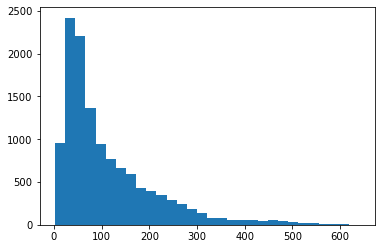

In [25]:
plt.hist(samples_comms_sizes['community_size'], density=False, bins=30)

In [18]:
set(samples_envo_features['env_material'])

{'animal habitation',
 'biofilm',
 'brackish water',
 'bulk soil',
 'coastal water',
 'dust',
 'excreta',
 'feces',
 'fresh water',
 'marine sediment',
 'mucus',
 'organic material',
 'rhizosphere',
 'saline water',
 'saliva',
 'sand',
 'sea water',
 'sebum',
 'sediment',
 'soil',
 'stream sediment',
 'surface layer',
 'travertine',
 'underground water',
 'wood'}

In [19]:
set(samples_envo_features['envo_biome_3'])

{'broadleaf forest biome',
 'coniferous forest biome',
 'cropland biome',
 'dense settlement biome',
 'freshwater lake biome',
 'freshwater river biome',
 'marine benthic biome',
 'marine pelagic biome',
 'montane grassland biome',
 nan,
 'rangeland biome',
 'village biome'}

In [23]:
set(samples_envo_features['empo_3'])

{'Animal corpus',
 'Animal distal gut',
 'Animal proximal gut',
 'Animal secretion',
 'Animal surface',
 'Plant corpus',
 'Plant rhizosphere',
 'Plant surface',
 'Sediment (non-saline)',
 'Sediment (saline)',
 'Soil (non-saline)',
 'Surface (non-saline)',
 'Surface (saline)',
 'Water (non-saline)',
 'Water (saline)'}

### Now we are subsetting the data frame for:

In [15]:
environment = 'soil'

In [16]:
soil_samples = samples_envo_features.loc[samples_envo_features['env_material'] == environment]
soil_samples

,sample,org_id,value,assembly_accession,Description,title,principal_investigator,ebi_accession,target_gene,sample_taxid,...,envo_biome_0,envo_biome_1,envo_biome_2,envo_biome_3,envo_biome_4,envo_biome_5,empo_0,empo_1,empo_2,empo_3
0,1001.SKB1,Acidovorax_konjaci_DSM_7481,0.004495,GCF_900112675.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
1,1001.SKB1,Acidovorax_soli_DSM_25157,0.000642,GCF_900107605.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
2,1001.SKB1,Acinetobacter_brisouii_CIP_110357,0.000161,GCF_000488275.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
3,1001.SKB1,Acinetobacter_indicus_CIP_110367,0.004495,GCF_000488255.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
4,1001.SKB1,Actinomadura_meyerae_DSM_44715,0.000642,GCF_900188445.1,Burmese bulk,Understanding cultivar-specificity and soil de...,Suzanne Kennedy,ERP016540,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408952,1721.BMC.7.5T.5.3,Pelagicola_litorisediminis_CECT_8287,0.000312,GCF_900172295.1,barley soil sample BMC.7.5T.5.3,Comparative analysis of the microbial communit...,Torsten Thomas,ERP016937,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
1408953,1721.BMC.7.5T.5.3,Pseudooceanicola_nitratireducens_DSM_29619,0.000156,GCF_900112545.1,barley soil sample BMC.7.5T.5.3,Comparative analysis of the microbial communit...,Torsten Thomas,ERP016937,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
1408954,1721.BMC.7.5T.5.3,Roseobacter_litoralis_Och_149,0.000156,GCF_000154785.2,barley soil sample BMC.7.5T.5.3,Comparative analysis of the microbial communit...,Torsten Thomas,ERP016937,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)
1408955,1721.BMC.7.5T.5.3,Thalassobius_mediterraneus_CECT_5383,0.000234,GCF_001458435.1,barley soil sample BMC.7.5T.5.3,Comparative analysis of the microbial communit...,Torsten Thomas,ERP016937,16S rRNA,410658,...,biome,terrestrial biome,anthropogenic terrestrial biome,cropland biome,NaN,NaN,EMP sample,Free-living,Non-saline,Soil (non-saline)


In [17]:
# Calculating community sizes
soil_community_sizes = soil_samples.groupby(['sample']).size().reset_index(name='community_size')
soil_community_sizes

,sample,community_size
0,1001.SKB1,267
1,1001.SKB2,253
2,1001.SKB3,274
3,1001.SKB4,293
4,1001.SKB5,252
...,...,...
1665,990.KA3U.E.20,275
1666,990.KA3U.E.21,149
1667,990.KA3U.E.22,255
1668,990.KA3U.E.24,247


(array([ 47.,  42.,  44.,  80.,  78., 100., 158., 205., 170., 183., 141.,
        112.,  93.,  79.,  52.,  33.,   8.,  14.,   4.,   6.,   5.,   1.,
          2.,   2.,   2.,   2.,   2.,   2.,   2.,   1.]),
 array([  5.        ,  25.33333333,  45.66666667,  66.        ,
         86.33333333, 106.66666667, 127.        , 147.33333333,
        167.66666667, 188.        , 208.33333333, 228.66666667,
        249.        , 269.33333333, 289.66666667, 310.        ,
        330.33333333, 350.66666667, 371.        , 391.33333333,
        411.66666667, 432.        , 452.33333333, 472.66666667,
        493.        , 513.33333333, 533.66666667, 554.        ,
        574.33333333, 594.66666667, 615.        ]),
 <BarContainer object of 30 artists>)

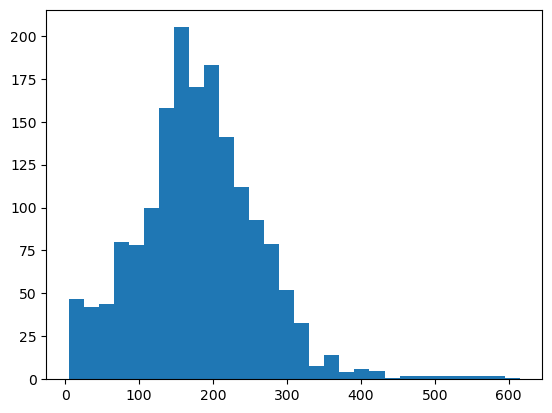

In [18]:
plt.hist(soil_community_sizes['community_size'], density=False, bins=30)

In [19]:
soil_community_sizes.nsmallest(20, 'community_size')

,sample,community_size
536,1721.B29M,5
542,1721.B3B,5
651,1721.S14T,5
534,1721.B27T,6
560,1721.BMC.7.1T.26.3,6
571,1721.BMC.8.1T.30.3,6
707,1721.Soil.NIL.100.N.14.1,6
708,1721.Soil.NIL.100.N.14.2,6
563,1721.BMC.7.5T.21.1,7
529,1721.B26B,8


In [20]:
soil_community_sizes.nlargest(20, 'community_size')

,sample,community_size
895,864.7.OTC.addV.addG.noW.lane2.NoIndex,615
760,864.11.OTC.addV.noG.addW.lane2.NoIndex,593
884,864.6.CON.addV.noG.noW.B.lane2.NoIndex,586
815,864.15.OTC.addV.noG.addW.lane2.NoIndex,565
892,864.7.CON.addV.addG.noW.B.lane2.NoIndex,554
749,864.10.CON.addV.noG.addW.lane2.NoIndex,541
793,864.14.CON.addV.noG.addW.lane2.NoIndex,535
901,864.8.OTC.addV.addG.noW.lane2.NoIndex,528
756,864.10.OTC.addV.noG.noW.lane2.NoIndex,517
799,864.14.OTC.addV.noG.addW.lane2.NoIndex,512


<br>

### After I will extract the 10 smallest communities per environmental material

In [21]:
envo = sorted(set(samples_envo_features['env_material']))

In [22]:
# envo = envo[0:2]
# envo

In [23]:
# I will run a for loop and store the results in a dataframe
full_samples = pd.DataFrame()

for material in envo:
    temp_sample = samples_envo_features.loc[samples_envo_features['env_material'] == material]
    temp_comm = temp_sample.groupby(['sample']).size().reset_index(name='community_size')
    temp_comm = temp_comm.nsmallest(10, 'community_size')
    
    temp_full_samples = pd.DataFrame()
    for index in range(len(temp_comm)):
        temp_id = temp_comm.iloc[index][0]
        temp_id_sample = temp_sample[temp_sample['sample'] == temp_id]
        temp_full_samples = pd.concat([temp_full_samples, temp_id_sample])
        
    full_samples = pd.concat([full_samples, temp_full_samples])


In [24]:
full_samples

,sample,org_id,value,assembly_accession,Description,title,principal_investigator,ebi_accession,target_gene,sample_taxid,...,envo_biome_0,envo_biome_1,envo_biome_2,envo_biome_3,envo_biome_4,envo_biome_5,empo_0,empo_1,empo_2,empo_3
1203782,1747.212070.holding.pen.B.debris,Arthrobacter_enclensis_NIO_1008,0.001934,GCF_001457025.1,212070 holding pen dust/debris (plant matter) ...,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Host-associated,Plant,Plant corpus
1203783,1747.212070.holding.pen.B.debris,Beutenbergia_cavernae_DSM_12333,0.001657,GCF_000023105.1,212070 holding pen dust/debris (plant matter) ...,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Host-associated,Plant,Plant corpus
1203784,1747.212070.holding.pen.B.debris,Buttiauxella_ferragutiae_ATCC_51602,0.002210,GCF_001654915.1,212070 holding pen dust/debris (plant matter) ...,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Host-associated,Plant,Plant corpus
1203785,1747.212070.holding.pen.B.debris,Cellvibrio_mixtus_subsp_mixtus_J3_8,0.001796,GCF_000766945.1,212070 holding pen dust/debris (plant matter) ...,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Host-associated,Plant,Plant corpus
1203786,1747.212070.holding.pen.B.debris,Paracoccus_halophilus_JCM_14014,0.000414,GCF_000763905.1,212070 holding pen dust/debris (plant matter) ...,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Host-associated,Plant,Plant corpus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101979,1747.DZF.6202012.RJ.log,Marinactinospora_thermotolerans_DSM_45154,0.000081,GCF_900167435.1,Raja log,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
101980,1747.DZF.6202012.RJ.log,Nitrococcus_mobilis_Nb_231,0.000464,GCF_000153205.1,Raja log,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
101981,1747.DZF.6202012.RJ.log,Nocardiopsis_halotolerans_DSM_44410,0.000282,GCF_000341065.1,Raja log,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
101982,1747.DZF.6202012.RJ.log,Clostridium_acetireducens_DSM_10703,0.000040,GCF_001758365.1,Raja log,The oral and skin microbiomes of captive Komod...,Rob Knight,ERP016252,16S rRNA,410656,...,biome,terrestrial biome,anthropogenic terrestrial biome,dense settlement biome,urban biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)


### To reduce the dataset and increase the speed of analysis I will remove the communities that have more than 10 species...for now!

In [25]:
small_communities = full_samples.groupby(['sample']).size().reset_index(name='community_size')
small_communities

,sample,community_size
0,1024.SH004.C1.RH.3.211.bulk.9.11.G1.L00,102
1,1024.SH007.C6.RH.5.185.flw.6.11.G1.L00,3
2,1064.W.CJV187,4
3,1222.B3.5.13.06,24
4,1222.B5.5.12.06,31
...,...,...
233,945.P10.E1.lane3.NoIndex.L003,10
234,945.P11.B6.lane3.NoIndex.L003,11
235,945.P11.D11.lane3.NoIndex.L003,13
236,945.P11.F9.lane3.NoIndex.L003,10


(array([49., 52., 57.,  5.,  7.,  5.,  1.,  7.,  5.,  3.,  1.,  6.,  3.,
         5.,  0.,  1.,  4.,  2.,  6.,  5.,  3.,  2.,  2.,  0.,  1.,  0.,
         0.,  2.,  2.,  2.]),
 array([  2.        ,  13.43333333,  24.86666667,  36.3       ,
         47.73333333,  59.16666667,  70.6       ,  82.03333333,
         93.46666667, 104.9       , 116.33333333, 127.76666667,
        139.2       , 150.63333333, 162.06666667, 173.5       ,
        184.93333333, 196.36666667, 207.8       , 219.23333333,
        230.66666667, 242.1       , 253.53333333, 264.96666667,
        276.4       , 287.83333333, 299.26666667, 310.7       ,
        322.13333333, 333.56666667, 345.        ]),
 <BarContainer object of 30 artists>)

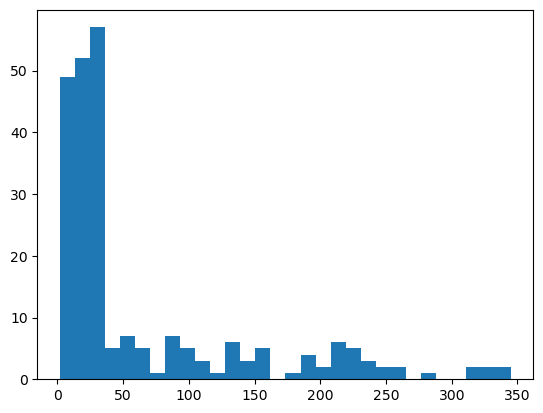

In [26]:
plt.hist(small_communities['community_size'], density=False, bins=30)

In [27]:
small_communities = small_communities[small_communities["community_size"].between(16,20)]
small_communities

,sample,community_size
5,1222.B5.5.7.06,20
10,1673.MBS0428.5,17
11,1673.MBS65.4,17
54,1773.Columb.talpa1.crop,17
55,1773.Columb.talpa4.crop,17
60,1883.2009.289.Crump.Artic.LTREB.main.lane3.NoI...,16
101,2192.H01a.Hand.208.lane2.NoIndex.L002,16
118,2192.H06b.Nose.3063.lane6.NoIndex.L006,19
120,2192.H06b.Nose.3177.lane6.NoIndex.L006,16
121,2192.H06b.Nose.3273.lane6.NoIndex.L006,17


In [28]:
small_sample_ids = sorted(set(small_communities['sample']))
small_comms_samples_meta = full_samples[full_samples['sample'].isin(small_sample_ids)]
small_comms_samples_meta

,sample,org_id,value,assembly_accession,Description,title,principal_investigator,ebi_accession,target_gene,sample_taxid,...,envo_biome_0,envo_biome_1,envo_biome_2,envo_biome_3,envo_biome_4,envo_biome_5,empo_0,empo_1,empo_2,empo_3
1289319,895.Puhimau.mat.2,Brachymonas_chironomi_DSM_19884,0.000068,GCF_000374625.1,geothermal field biofilm,Kilauea geothermal soils and biofilms,Gary M. King,ERP020591,16S rRNA,718308,...,biome,terrestrial biome,forest biome,coniferous forest biome,tropical coniferous forest biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
1289320,895.Puhimau.mat.2,Methylocapsa_palsarum_NE2,0.000541,GCF_900114285.1,geothermal field biofilm,Kilauea geothermal soils and biofilms,Gary M. King,ERP020591,16S rRNA,718308,...,biome,terrestrial biome,forest biome,coniferous forest biome,tropical coniferous forest biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
1289321,895.Puhimau.mat.2,Rhodomicrobium_vannielii_ATCC_17100,0.003587,GCF_000166055.1,geothermal field biofilm,Kilauea geothermal soils and biofilms,Gary M. King,ERP020591,16S rRNA,718308,...,biome,terrestrial biome,forest biome,coniferous forest biome,tropical coniferous forest biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
1289322,895.Puhimau.mat.2,Frateuria_terrea_CGMCC_1_7053,0.000203,GCF_900115705.1,geothermal field biofilm,Kilauea geothermal soils and biofilms,Gary M. King,ERP020591,16S rRNA,718308,...,biome,terrestrial biome,forest biome,coniferous forest biome,tropical coniferous forest biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
1289323,895.Puhimau.mat.2,Caballeronia_glathei_DSM_50014,0.000068,GCF_000698595.1,geothermal field biofilm,Kilauea geothermal soils and biofilms,Gary M. King,ERP020591,16S rRNA,718308,...,biome,terrestrial biome,forest biome,coniferous forest biome,tropical coniferous forest biome,NaN,EMP sample,Free-living,Non-saline,Surface (non-saline)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369523,1883.2009.289.Crump.Artic.LTREB.main.lane3.NoI...,Sphingomonas_paucimobilis_NBRC_13935,0.003357,GCF_000739895.2,soil water,Microbial diversity in arctic freshwaters is s...,Byron Crump,ERP017459,16S rRNA,449393,...,biome,terrestrial biome,tundra biome,NaN,NaN,NaN,EMP sample,Free-living,Non-saline,Water (non-saline)
1369524,1883.2009.289.Crump.Artic.LTREB.main.lane3.NoI...,Kutzneria_albida_DSM_43870,0.009131,GCF_000525635.1,soil water,Microbial diversity in arctic freshwaters is s...,Byron Crump,ERP017459,16S rRNA,449393,...,biome,terrestrial biome,tundra biome,NaN,NaN,NaN,EMP sample,Free-living,Non-saline,Water (non-saline)
1369525,1883.2009.289.Crump.Artic.LTREB.main.lane3.NoI...,Xanthomonas_gardneri_ICMP7383,0.002954,GCF_001908775.1,soil water,Microbial diversity in arctic freshwaters is s...,Byron Crump,ERP017459,16S rRNA,449393,...,biome,terrestrial biome,tundra biome,NaN,NaN,NaN,EMP sample,Free-living,Non-saline,Water (non-saline)
1369526,1883.2009.289.Crump.Artic.LTREB.main.lane3.NoI...,Geobacter_daltonii_FRC_32,0.006043,GCF_000022265.1,soil water,Microbial diversity in arctic freshwaters is s...,Byron Crump,ERP017459,16S rRNA,449393,...,biome,terrestrial biome,tundra biome,NaN,NaN,NaN,EMP sample,Free-living,Non-saline,Water (non-saline)


In [29]:
small_communities['community_size'].sum()

461

In [45]:
sample_list = sorted(set(small_comms_samples_meta["sample"]))
sample_list 

['1222.B5.5.7.06',
 '1673.MBS0428.5',
 '1673.MBS65.4',
 '1773.Columb.talpa1.crop',
 '1773.Columb.talpa4.crop',
 '1883.2009.289.Crump.Artic.LTREB.main.lane3.NoIndex',
 '2192.H01a.Hand.208.lane2.NoIndex.L002',
 '2192.H06b.Nose.3063.lane6.NoIndex.L006',
 '2192.H06b.Nose.3177.lane6.NoIndex.L006',
 '2192.H06b.Nose.3273.lane6.NoIndex.L006',
 '662.M18',
 '678.seasonal.insitu.sample.491',
 '678.seasonal.insitu.sample.595',
 '723.C9.0m.G3.Catlin1.16Spool.110602.HWI.EAS137R.0375.s.3.1.sequence',
 '755.EF.EPSILON.09.06.11.lane3.NoIndex.L003',
 '755.EF.ETA.09.06.11.lane3.NoIndex.L003',
 '755.LSSF.THETA.D15.22.07.11.lane3.NoIndex.L003',
 '755.MP.Mock.bacteria.2.archae.lane3.NoIndex.L003',
 '755.SSF.uneven.mix6.lane3.NoIndex.L003',
 '804.LS11.127',
 '804.LS11.128',
 '804.LS11.72a',
 '895.Puhimau.mat.2',
 '905.Alsback.0.25to0.5cm',
 '905.Alsback.0to0.25cm',
 '905.Gullmarsfjord.stations1']

In [ ]:
for index in range(len(sample_list)):
        temp_id = sample_list[index]
        temp_id_sample = small_comms_samples_meta[small_comms_samples_meta['sample'] == temp_id]
        
        temp_id_sample.to_csv("./sampled_acessions.csv", index=False, header=False,
                              columns=['assembly_accession', 'sample', 'org_id'])
        
        !bash ./get_acessions.sh

Carving...
mkdir: output/1222.B5.5.7.06: File exists
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_900113825.1.faa.gz -o GCF_900113825.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_002201315.1.faa.gz -o GCF_002201315.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001550135.1.faa.gz -o GCF_001550135.1.faa.tsv --more-sensitive --top 10
L

/Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/smetana/smetana.py:263: UserWarning: MIP: Failed to find a valid solution for non-interacting community
  warn('MIP: Failed to find a valid solution for non-interacting community')
Running MRO for community all on medium complete...
Done.
Loading community: all
Running SCS for community all on medium minimal...
Running MUS for community all on medium minimal...
Running MPS for community all on medium minimal...
Done.
Completed!!!
Carving...
mkdir: output/1673.MBS0428.5: File exists
File exists, skipping.
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_900107605.1.faa.gz -o GCF_900107605.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
File exists, skipping.
Running diamond...
diamond blastp -d

Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001457025.1.faa.gz -o GCF_001457025.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000803645.1.faa.gz -o GCF_000803645.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001484935.1.faa.gz -o GCF_001484935.1.faa.tsv --

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000741135.1.faa.gz -o GCF_000741135.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_002015075.1.faa.gz -o GCF_002015075.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_002015075.1.faa.gz -o GCF_002015075.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000296835.1.faa.gz -o GCF_000296835.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000190755.2.faa.gz -o GCF_000190755.2.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001931675.1.faa.gz -o GCF_001931675.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000010185.1.faa.gz -o GCF_000010185.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_900101865.1.faa.gz -o GCF_900101865.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001543285.1.faa.gz -o GCF_001543285.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001275345.1.faa.gz -o GCF_001275345.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Loading community: all
Running MIP for community all on medium complete...
Running MRO for community all on medium complete...
Done.
Loading community: all
Running SCS for community all on medium minimal...
Running MUS for community all on medium minimal...
Running MPS for community all on medium minimal...
Done.
Completed!!!
Carving...
mkdir: output/2192.H06b.Nose.3273.lane6.NoIndex.L006: File exists
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_002115725.1.faa.gz -o GCF_002115725.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/ca

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000015285.1.faa.gz -o GCF_000015285.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_900101915.1.faa.gz -o GCF_900101915.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

/Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/smetana/smetana.py:160: UserWarning: MUS: Failed to find a minimal growth medium for Psychromonas_ingrahamii_37_
  warn('MUS: Failed to find a minimal growth medium for ' + org_id)
/Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/smetana/smetana.py:160: UserWarning: MUS: Failed to find a minimal growth medium for Shewanella_japonica_KCTC_22435_
  warn('MUS: Failed to find a minimal growth medium for ' + org_id)
/Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/smetana/smetana.py:160: UserWarning: MUS: Failed to find a minimal growth medium for Shewanella_pealeana_ATCC_700345_
  warn('MUS: Failed to find a minimal growth medium for ' + org_id)
/Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/smetana/smetana.py:160: UserWarning: MUS: Failed to find a minimal growth medium for Sulfitobacter_geojensis_MM_124_
  warn('MUS: Failed to find a minim

Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_001723355.1.faa.gz -o GCF_001723355.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000787395.1.faa.gz -o GCF_000787395.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Loading community: all
Running MIP for community all on medium complete...
/Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/smetana/smetana.py:263: UserWarning: MIP: Failed to find a valid solution for non-interacting community
  warn('MIP: Failed to find a val

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000266945.1.faa.gz -o GCF_000266945.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000012885.1.faa.gz -o GCF_000012885.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000018025.1.faa.gz -o GCF_000018025.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_000014705.1.faa.gz -o GCF_000014705.1.faa.tsv --more-sensitive --top 10
Loading universe model...
Scoring reactions...
Reconstructing a single model
Done.
waiting for carve
removing stuff to trash
Running diamond...
diamond blastp -d /Users/vitorferreira/miniconda3/envs/project/lib/python3.10/site-packages/carveme/data/generated/bigg_proteins.dmnd -q GCF_0

In [31]:
# p = subprocess.Popen(["bash", "./get_acessions.sh"], stdout=subprocess.PIPE)
# stdout, sterr = p.communicate()
        
# print(stdout.decode())

In [32]:
# def processing_interactions(task):
#     temp_id = task
#     temp_id_sample = small_comms_samples_meta[small_comms_samples_meta['sample'] == temp_id]
    
#     temp_id_sample.to_csv("./sampled_acessions.csv", index=False, header=False,
#                               columns=['assembly_accession', 'sample', 'org_id'])
    
#     !bash ./get_acessions.sh

In [44]:
# p = multiprocessing.Pool(processes=len(sample_list))

# for line in sample_list:
#     p = multiprocessing.Process(target=processing_interactions, args=(line,))
#     p.start()

# p.close()



# print("Complete")
# end = time.time()
# print("total time (s) =" + str(end-start))

In [ ]:
#temp_id_sample['assembly_accession']

In [ ]:
# for index in range(len(sample_list)):
#         temp_id = sample_list[index]
#         temp_id_sample = small_comms_samples_meta[small_comms_samples_meta['sample'] == temp_id]
        
#         for org in range(len(temp_id_sample)):
#             acession = temp_id_sample.iloc[org]['assembly_accession']
#             download_ncbi_genome(acession, refseq)
            